<a href="https://colab.research.google.com/github/miguel-kjh/Analysis-of-tweets/blob/main/tweets_preparing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation 

This script focuses on data preparation. Our data set is about tweets posted about a Spanish airline. What interests us to carry out the sentimineot analysis are simply the tweets and their category.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import string

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/SIANI Master/CI/Práctica/spanish-arilines-tweets-sentiment-analysis'
!ls '/content/drive/My Drive/SIANI Master/CI/Práctica/spanish-arilines-tweets-sentiment-analysis'

baseline.ipynb	      train_data_un.csv   tweets_submission.csv
sampleSubmission.csv  tweets_public.csv   val_data_un.csv
test_data_un.csv      tweets_public.xlsx


In [ ]:
tweet_df = pd.read_csv("%s/tweets_public.csv" %data_dir, encoding='utf-8', index_col='tweet_id')
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7867 entries, 926419989107798016 to 935546571663527936
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  7867 non-null   object
 1   is_reply           7867 non-null   bool  
 2   reply_count        7867 non-null   int64 
 3   retweet_count      7867 non-null   int64 
 4   text               7867 non-null   object
 5   tweet_coord        20 non-null     object
 6   tweet_created      7867 non-null   object
 7   tweet_location     419 non-null    object
 8   user_timezone      5100 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 560.8+ KB


The next cell shows all the transformations to be performed on the texts and operations to store the data in CSV format 

In [ ]:
def transforms_lables(label):
  if (label == 'negative'):
    return 0
  if (label == 'neutral'):
    return 1
  if (label == 'positive'):
    return 2

def processing_tweet(tweet: str) -> str:
  tweet = re.sub(r'https?://\S+|www\.\S+', r'', tweet) # remove URLS
  tweet = re.sub(r"[^\w\s\d]","", tweet) # remove pnctuations
  tweet = re.sub(r'@\w+','', tweet) # remove mentions
  tweet = re.sub(r'#\w+','', tweet) # remove hash
  tweet = re.sub(r"\s+"," ", tweet).strip() # remove space
  tweet = re.sub("\S*\d\S*", "", tweet).strip()
  tweet = ' '.join([letter for letter in nltk.word_tokenize(tweet) 
                   if letter not in stopwords.words('spanish')]) # deleted stop words
  return tweet.lower()


def processing_tweets(tweets: list) -> list:
  return [ processing_tweet(sentance) for sentance in tweets]

class tweet:
  def __init__(self, comment: str, sentiment: int):
    self.comment   = comment
    self.sentiment = sentiment

  def getListAttribute(self) -> list:
    return [self.comment, self.sentiment]

def save_in_csv(data: list, name: str) -> None:
  df = pd.DataFrame([ sample.getListAttribute() for sample in data])
  df.columns = ['quote', 'score']
  df.to_csv(name,index = False)

The dataset has been analyzed, as it is quite badly balanced, two data sets have been created to test the behavior of the models with them, one unbalanced and the other balanced.

## UnBalanced

In [ ]:
TWEETS = list(tweet_df["text"])
sentiments = list(map(lambda x: transforms_lables(x),tweet_df["airline_sentiment"]))

In [ ]:
print(TWEETS[0])
print(sentiments[0])

Trabajar en #Ryanair como #TMA: https://t.co/ruUArBe1tO #empleo
1


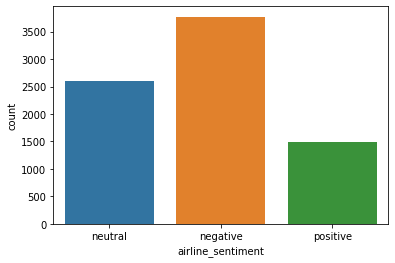

In [ ]:
sns.countplot(x = 'airline_sentiment', data = tweet_df)

In [ ]:
data = [tweet(comment, sentiment) for comment, sentiment in zip(processing_tweets(TWEETS), sentiments)]
for i in range(1,10):
  print(data[i].comment)

iberia fionaferrer cuando gusten cancún viaja disfruta manera igual
sabiais iberia trata bien santiago chilete cambia asientote manda volar wc traseroe
nunca nunca nunca pidáis café ryanair bueno vendan bordo
cris_tortu dakar iberia mitsubishi_es bfgoodricheu burgostur astintlogistics uremovil karbium muchos éxito
wow bonito solo volado unas veces iberia siempre tierra
iberia plus cumple años queremos celebrarlo contigo manera especial elige número favorito
barómetro business iberia vueling compañías aéreas utilizadas viajes
iberia felicitaciones iberia
cbellolio iberia nuevopudahuel chuata madrid stgo par semanas habrá cruzar dedos


In [ ]:
random.shuffle(data)

split     = round(len(data)*0.70)
increment = round(len(data)*0.20)

train_data, val_data, test_data = data[:split],data[split:split+increment],data[split+increment:]

print(len(train_data))
print(len(val_data))
print(len(test_data))

5507
1573
787


In [ ]:
save_in_csv(train_data, "%s/train_data_un.csv" %data_dir)
save_in_csv(test_data,  "%s/test_data_un.csv"  %data_dir)
save_in_csv(val_data,   "%s/val_data_un.csv"   %data_dir)

## Balanced

In [ ]:
tweet_df = pd.read_csv("%s/tweets_public.csv" %data_dir, encoding='utf-8', index_col='tweet_id')
tweet_df = pd.DataFrame([tweet_df['text'], tweet_df['airline_sentiment']]).transpose()
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7867 entries, 926419989107798016 to 935546571663527936
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               7867 non-null   object
 1   airline_sentiment  7867 non-null   object
dtypes: object(2)
memory usage: 504.4+ KB


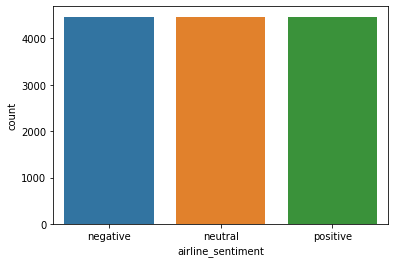

In [ ]:
tweet_df = tweet_df.groupby('airline_sentiment')
tweet_df = pd.DataFrame(tweet_df.apply(
    lambda x: tweet_df.sample(tweet_df.size().min()).reset_index(drop=True)
    )
)

sns.countplot(x = 'airline_sentiment', data = tweet_df)

In [ ]:
TWEETS = list(tweet_df["text"])
sentiments = list(map(lambda x: transforms_lables(x),tweet_df["airline_sentiment"]))

In [ ]:
data = [tweet(comment, sentiment) for comment, sentiment in zip(processing_tweets(TWEETS), sentiments)]
for i in range(1,10):
  print(data[i].comment)

oleada huelgas ryanair navidades
sociedad los pilotos ryanair irlanda desconvocan huelga horas la aerolínea reconocerá sind
con iberia destino solo click deseadme suerte holacolombia hola destinos europeos mejor precio
jhonatanrval avianca iberia ole sevan robar maleta pacora restrepo avianca iberia ve aca colom
ryanair pilotos italia si huelga sanción vivan derechos
colocolo grandes problemas equipos surtemuco udeconce iberia rematar tocan últi
ryanair afronta primera huelga pilotos historia
iberia masterchef_es increiblemente malo servicio atención cliente iberia recuperen ya valijas d
iberia además hojas reclamación avión preceptivo absolutamente inaceptable comportamiento


In [ ]:
random.shuffle(data)

split     = round(len(data)*0.70)
increment = round(len(data)*0.20)

train_data, val_data, test_data = data[:split],data[split:split+increment],data[split+increment:]

print(len(train_data))
print(len(val_data))
print(len(test_data))

9381
2680
1340


In [ ]:
save_in_csv(train_data, "%s/train_data_ba.csv" %data_dir)
save_in_csv(test_data,  "%s/test_data_ba.csv"  %data_dir)
save_in_csv(val_data,   "%s/val_data_ba.csv"   %data_dir)